In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [326]:
df = pd.read_csv("dataset/Customers.csv")
df.dropna(inplace=True)
df.rename(
    columns={
        "Spending Score (1-100)": "Spending Score",
        "Annual Income ($)": "Annual Income",
    },
    inplace=True,
)
df.head()


,CustomerID,Gender,Age,Annual Income,Spending Score,Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


#### Convert categorical features (Gender, Profession) into numerical values


In [327]:
# Label encoding for Gender
le_gender = LabelEncoder()
df["Gender"] = le_gender.fit_transform(df["Gender"])
df.head()


,CustomerID,Gender,Age,Annual Income,Spending Score,Profession,Work Experience,Family Size
0,1,1,19,15000,39,Healthcare,1,4
1,2,1,21,35000,81,Engineer,3,3
2,3,0,20,86000,6,Engineer,1,1
3,4,0,23,59000,77,Lawyer,0,2
4,5,0,31,38000,40,Entertainment,2,6


In [328]:
# One-hot encoding for Profession
ohe_profession = OneHotEncoder(sparse_output=False)
# encode the categorical variable Profession into binary variables
transformed_professions = ohe_profession.fit_transform(df[["Profession"]])
# returns an array of feature names corresponding to the unique values in the original Profession column
profession_columns = ohe_profession.get_feature_names_out(["Profession"])
# create new DataFrame called df_professions from the transformed_professions array, using the profession_columns as column names
df_professions = pd.DataFrame(transformed_professions, columns=profession_columns)
# combines the original DataFrame with the new df_professions DataFrame
df = pd.concat([df, df_professions], axis=1).drop("Profession", axis=1)
df.dropna(inplace=True)


#### Normalize the numerical features


Features in a dataset may have different scales or units of measurement. For example, in the hop Customer Data dataset, Age is measured in years, Annual Income is measured in dollars, and Spending Score is a unitless value between 0 and 100. Without scaling, features with larger magnitudes (e.g., Annual Income) could dominate the distance calculations, resulting in a biased clustering outcome. In conclusion, normalizing features ensure that each feature contributes equally to the distance calculation


In [329]:
# normalizes the features of a dataset to have zero mean and unit variance
scalar = StandardScaler()
# scaling to each feature by subtracting the mean and dividing by the standard deviation
scaled_features = scalar.fit_transform(
    df
)  # scaled features are stored in a new NumPy array
df_scaled = pd.DataFrame(scaled_features, columns=df.columns)
df_scaled.head()


,CustomerID,Gender,Age,Annual Income,Spending Score,Work Experience,Family Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,-1.727878,1.211623,-1.049701,-2.078305,-0.427153,-0.772755,0.122021,-0.672473,-0.300658,-0.315777,-0.369637,-0.288189,2.178083,-0.177578,-0.277505,-0.209302
1,-1.726117,1.211623,-0.979277,-1.642790,1.074886,-0.263999,-0.386620,-0.672473,-0.300658,3.166792,-0.369637,-0.288189,-0.459119,-0.177578,-0.277505,-0.209302
2,-1.724357,-0.825339,-1.014489,-0.532228,-1.607326,-0.772755,-1.403902,-0.672473,-0.300658,3.166792,-0.369637,-0.288189,-0.459119,-0.177578,-0.277505,-0.209302
3,-1.722596,-0.825339,-0.908853,-1.120173,0.931835,-1.027133,-0.895261,-0.672473,-0.300658,-0.315777,-0.369637,-0.288189,-0.459119,-0.177578,3.603541,-0.209302
4,-1.720836,-0.825339,-0.627157,-1.577463,-0.391390,-0.518377,1.139303,-0.672473,-0.300658,-0.315777,2.705359,-0.288189,-0.459119,-0.177578,-0.277505,-0.209302


#### Clustering


In [330]:
selected_features = ["Annual Income", "Spending Score"]
X = df_scaled[selected_features]

#### Use the Elbow method to find the optimal number of clusters

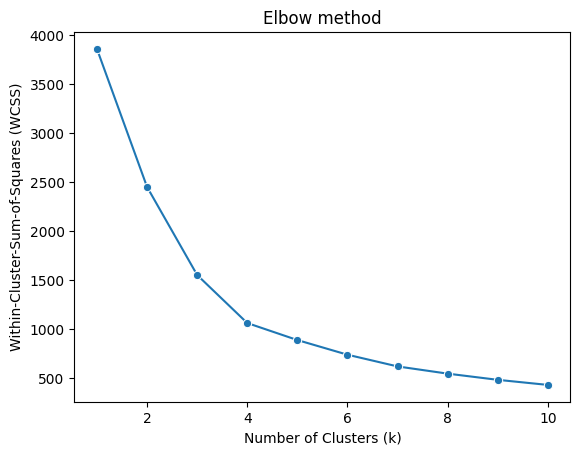

In [331]:
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

sns.lineplot(x=k_values, y=wcss, marker='o')
plt.title('Elbow method')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster-Sum-of-Squares (WCSS)")
plt.show()

#### Use the Silhouette method to find the optimal number of clusters
The Silhouette Score measures how similar each data point is to its own cluster compared to other clusters. It ranges from -1 to 1, where a higher score indicates better clustering.

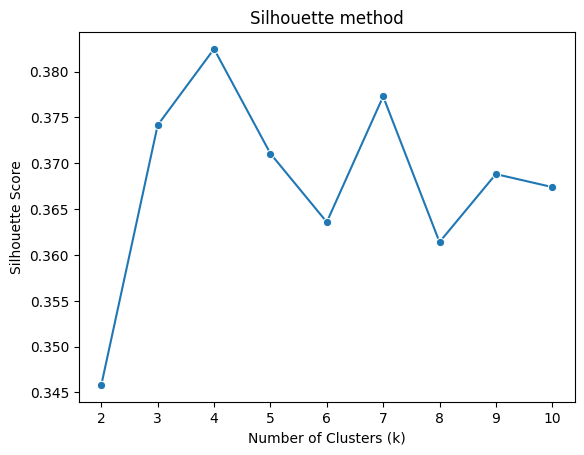

In [332]:
silhouette_scores = []

for k in k_values[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    # returns the cluster labels for each data point in X
    cluster_labels = kmeans.fit_predict(X)
    # calculate the Silhouette Score for the current clustering solution using the silhouette_score function
    # This function takes the scaled data X and cluster labels as input and returns the Silhouette Score for the solution.
    silhouette_scores.append(silhouette_score(X, cluster_labels))

sns.lineplot(x=k_values[1:], y=silhouette_scores, marker='o')
plt.title("Silhouette method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


Set the optimal number of clusters and fit the KMeans model

In [333]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X) # cluster labels for each data point


In [334]:
df["Cluster"] = cluster_labels # Add the cluster labels to the original DataFrame


Visualize the clustering result using a scatter plot

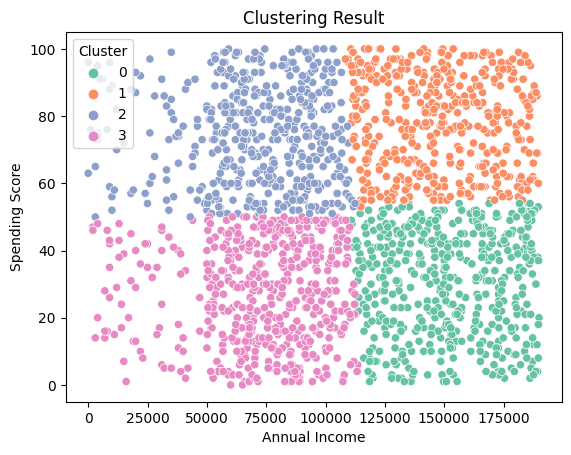

In [335]:
sns.scatterplot(data=df, x="Annual Income", y="Spending Score", hue="Cluster", palette="Set2")
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('Clustering Result')
plt.show()